In [1]:
!pip install onnxruntime opencv-python numpy huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 71.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.5 MB/s eta 0:00:00


In [2]:
!pip install optimum[onnxruntime]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [3]:
import time
import cv2
import numpy as np
import onnxruntime


In [4]:
import numpy as np

def xywh2xyxy(boxes):
    boxes_xyxy = np.copy(boxes)
    boxes_xyxy[..., 0] = boxes[..., 0] - boxes[..., 2] / 2  # x1
    boxes_xyxy[..., 1] = boxes[..., 1] - boxes[..., 3] / 2  # y1
    boxes_xyxy[..., 2] = boxes[..., 0] + boxes[..., 2] / 2  # x2
    boxes_xyxy[..., 3] = boxes[..., 1] + boxes[..., 3] / 2  # y2
    return boxes_xyxy

def compute_iou(box, boxes):
    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    inter_area = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)

    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])


    union_area = box_area + boxes_area - inter_area

    iou = inter_area / union_area
    return iou

def nms(boxes, scores, iou_threshold=0.5):
    sorted_indices = np.argsort(scores)[::-1]
    keep = []

    while len(sorted_indices) > 0:
        current = sorted_indices[0]
        keep.append(current)

        if len(sorted_indices) == 1:
            break

        rest = sorted_indices[1:]
        ious = compute_iou(boxes[current], boxes[rest])

        sorted_indices = rest[ious < iou_threshold]

    return keep

def multiclass_nms(boxes, scores, class_ids, iou_threshold=0.5):
    keep_all = []

    for cls in np.unique(class_ids):
        cls_indices = np.where(class_ids == cls)[0]
        cls_boxes = boxes[cls_indices]
        cls_scores = scores[cls_indices]

        cls_keep = nms(cls_boxes, cls_scores, iou_threshold)
        keep_all.extend(cls_indices[cls_keep])

    return keep_all


In [5]:
CLASS_MEAN_HEIGHT = {
    'person': 1.75,
    'bicycle': 1.6,
    'car': 1.5,
    'bus': 3.0,
    'truck': 3.0,
    'motorcycle': 1.4
}

FOCAL_PX = 1200 

In [11]:
class YOLOv8:

    def __init__(self, path, conf_thres=0.7, iou_thres=0.5):
        self.iou_thres = iou_thres
        self.conf_thres = conf_thres

        self.initialize_model_session(path)

    def __call__(self, image):
        return self.detect_objects(image)
        
    def initialize_model_session(self,path):
        self.session = onnxruntime.InferenceSession(path, 
                                                    providers=["CPUExecutionProvider"],
                                                    sess_options=onnxruntime.SessionOptions())

    def prepare_input(self, image):
        self.img_height, self.img_width = image.shape[:2]

        input_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        input_img = cv2.resize(input_img, (self.input_width, self.input_height))
        input_img = input_img / 255.0
        input_img = input_img.transpose(2, 0, 1)
        input_tensor = input_img[np.newaxis, :, :, :].astype(np.float32)

        return input_tensor

    def inference(self, input_tensor):
        start = time.perf_counter()
        outputs = self.session.run(self.output_names, {self.input_names[0] : input_tensor})
        return outputs

    def get_class_name(self, cls_id):
        coco_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck']
        if cls_id < len(coco_names):
            return coco_names[cls_id]
        return f"class{cls_id}"

    def process_output(self, outputs):
        predictions = np.squeeze(outputs[0]).T
        scores = np.max(predictions[:, 4:], axis=1)
        predictions = predictions[scores>self.conf_thres, :]
        scores = scores[scores > self.conf_thres]

        if len(scores) == 0:
            return [], [], [], []

        cls_ids = np.argmax(predictions[:, 4:], axis=1)
        boxes = self.extract_boxes(predictions)

        indices = multiclass_nms(boxes, scores, cls_ids, self.iou_thres)

        boxes, scores, cls_ids = boxes[indices], scores[indices], cls_ids[indices]

        distances = []
        for box, cls_id in zip(boxes, cls_ids):
            x1, y1, x2, y2 = box
            pixel_h = max(1, y2-y1)
            cls_name = self.get_class_name(cls_id)
            real_h = CLASS_MEAN_HEIGHT.get(cls_name, 1.5)
            dist_m = FOCAL_PX * real_h / pixel_h
            distances.append(dist_m)

        return boxes, scores, cls_ids, distances
        
        
    def detect_objects(self, image):
        input_tensor = self.prepare_input(image)
        outputs = self.inference(input_tensor)

        self.boxes, self.scores, self.class_ids, self.distances = self.process_output(outputs)
        return self.boxes, self.scores, self.class_ids, self.distances

    def extract_boxes(self, predictions):
        boxes = predictions[:, :4]
        boxes = self.rescale_boxes(boxes)
        boxes = xywh2xyxy(boxes)
        return boxes

    def rescale_boxes(self, boxes):
        input_shape = np.array([self.input_width, self.input_height, self.input_width, self.input_height])
        boxes = np.divide(boxes, input_shape, dtype=np.float32)
        boxes *= np.array([self.img_width, self.img_height, self.img_width, self.img_height])
        return boxes

    def draw_detections(self, image, draw_scores=True, mask_alpha=0.4):
        img_out = image.copy()
        for box, score, cls_id, dist in zip(self.boxes, self.scores, self.class_ids, self.distances):
            x1, y1, x2, y2 = box.astype(int)
            label = f"{self.get_class_name(cls_id)} {score:.2f} {dist:.1f}m"
            cv2.rectangle(img_out, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_out, label, (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        return img_out

    def get_class_name(self, cls_id):
        coco_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat']
        if cls_id < len(coco_names):
            return coco_names[cls_id]
        return f"class{cls_id}"

    def get_input_details(self):
        model_inputs = self.session.get_inputs()
        self.input_names = [model_inputs[i].name for i in range(len(model_inputs))]
        self.input_shape = model_inputs[0].shape
        self.input_height = self.input_shape[2]
        self.input_width = self.input_shape[3]

    def get_output_details(self):
        model_outputs = self.session.get_outputs()
        self.output_names = [model_outputs[i].name for i in range(len(model_outputs))]


In [7]:
import cv2

video_path = "/kaggle/input/videodashcam/DashCam.mp4"
output_path = "video_10s.mp4"

cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count_limit = int(fps * 10)  # 10 секунд

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret or frame_idx >= frame_count_limit:
        break

    out.write(frame)
    frame_idx += 1

cap.release()
out.release()
print(f"Видео обрезано до 10 секунд и сохранено: {output_path}")


Видео обрезано до 10 секунд и сохранено: video_10s.mp4


In [12]:
model_path = '/kaggle/input/yolo8n.onnx/onnx/default/1/YOLO8n.onnx' 
detector = YOLOv8(model_path, conf_thres=0.3, iou_thres=0.5)
detector.get_input_details()
detector.get_output_details()

video_path = "video_10s.mp4"
cap = cv2.VideoCapture(video_path)


fourcc = cv2.VideoWriter_fourcc(*"mp4v")   
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter("output.mp4", fourcc, fps, (w, h))

frame_count = 0
total_infer_time = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    t0 = time.time()
    boxes, scores, cls_ids, distances = detector(frame)
    t_infer = time.time() - t0
    total_infer_time += t_infer

    frame_out = detector.draw_detections(frame)

    out.write(frame_out)
    frame_count += 1

cap.release()
out.release()

print(f"Обработка завершена. Видео сохранено: output.mp4")
print(f"Кадров обработано: {frame_count}")
print(f"Среднее время инференса: {total_infer_time/frame_count*1000:.1f} ms/кадр")
print(f"FPS: {frame_count/total_infer_time:.2f}")

Обработка завершена. Видео сохранено: output.mp4
Кадров обработано: 299
Среднее время инференса: 157.6 ms/кадр
FPS: 6.35


 Оригинальный кадр:


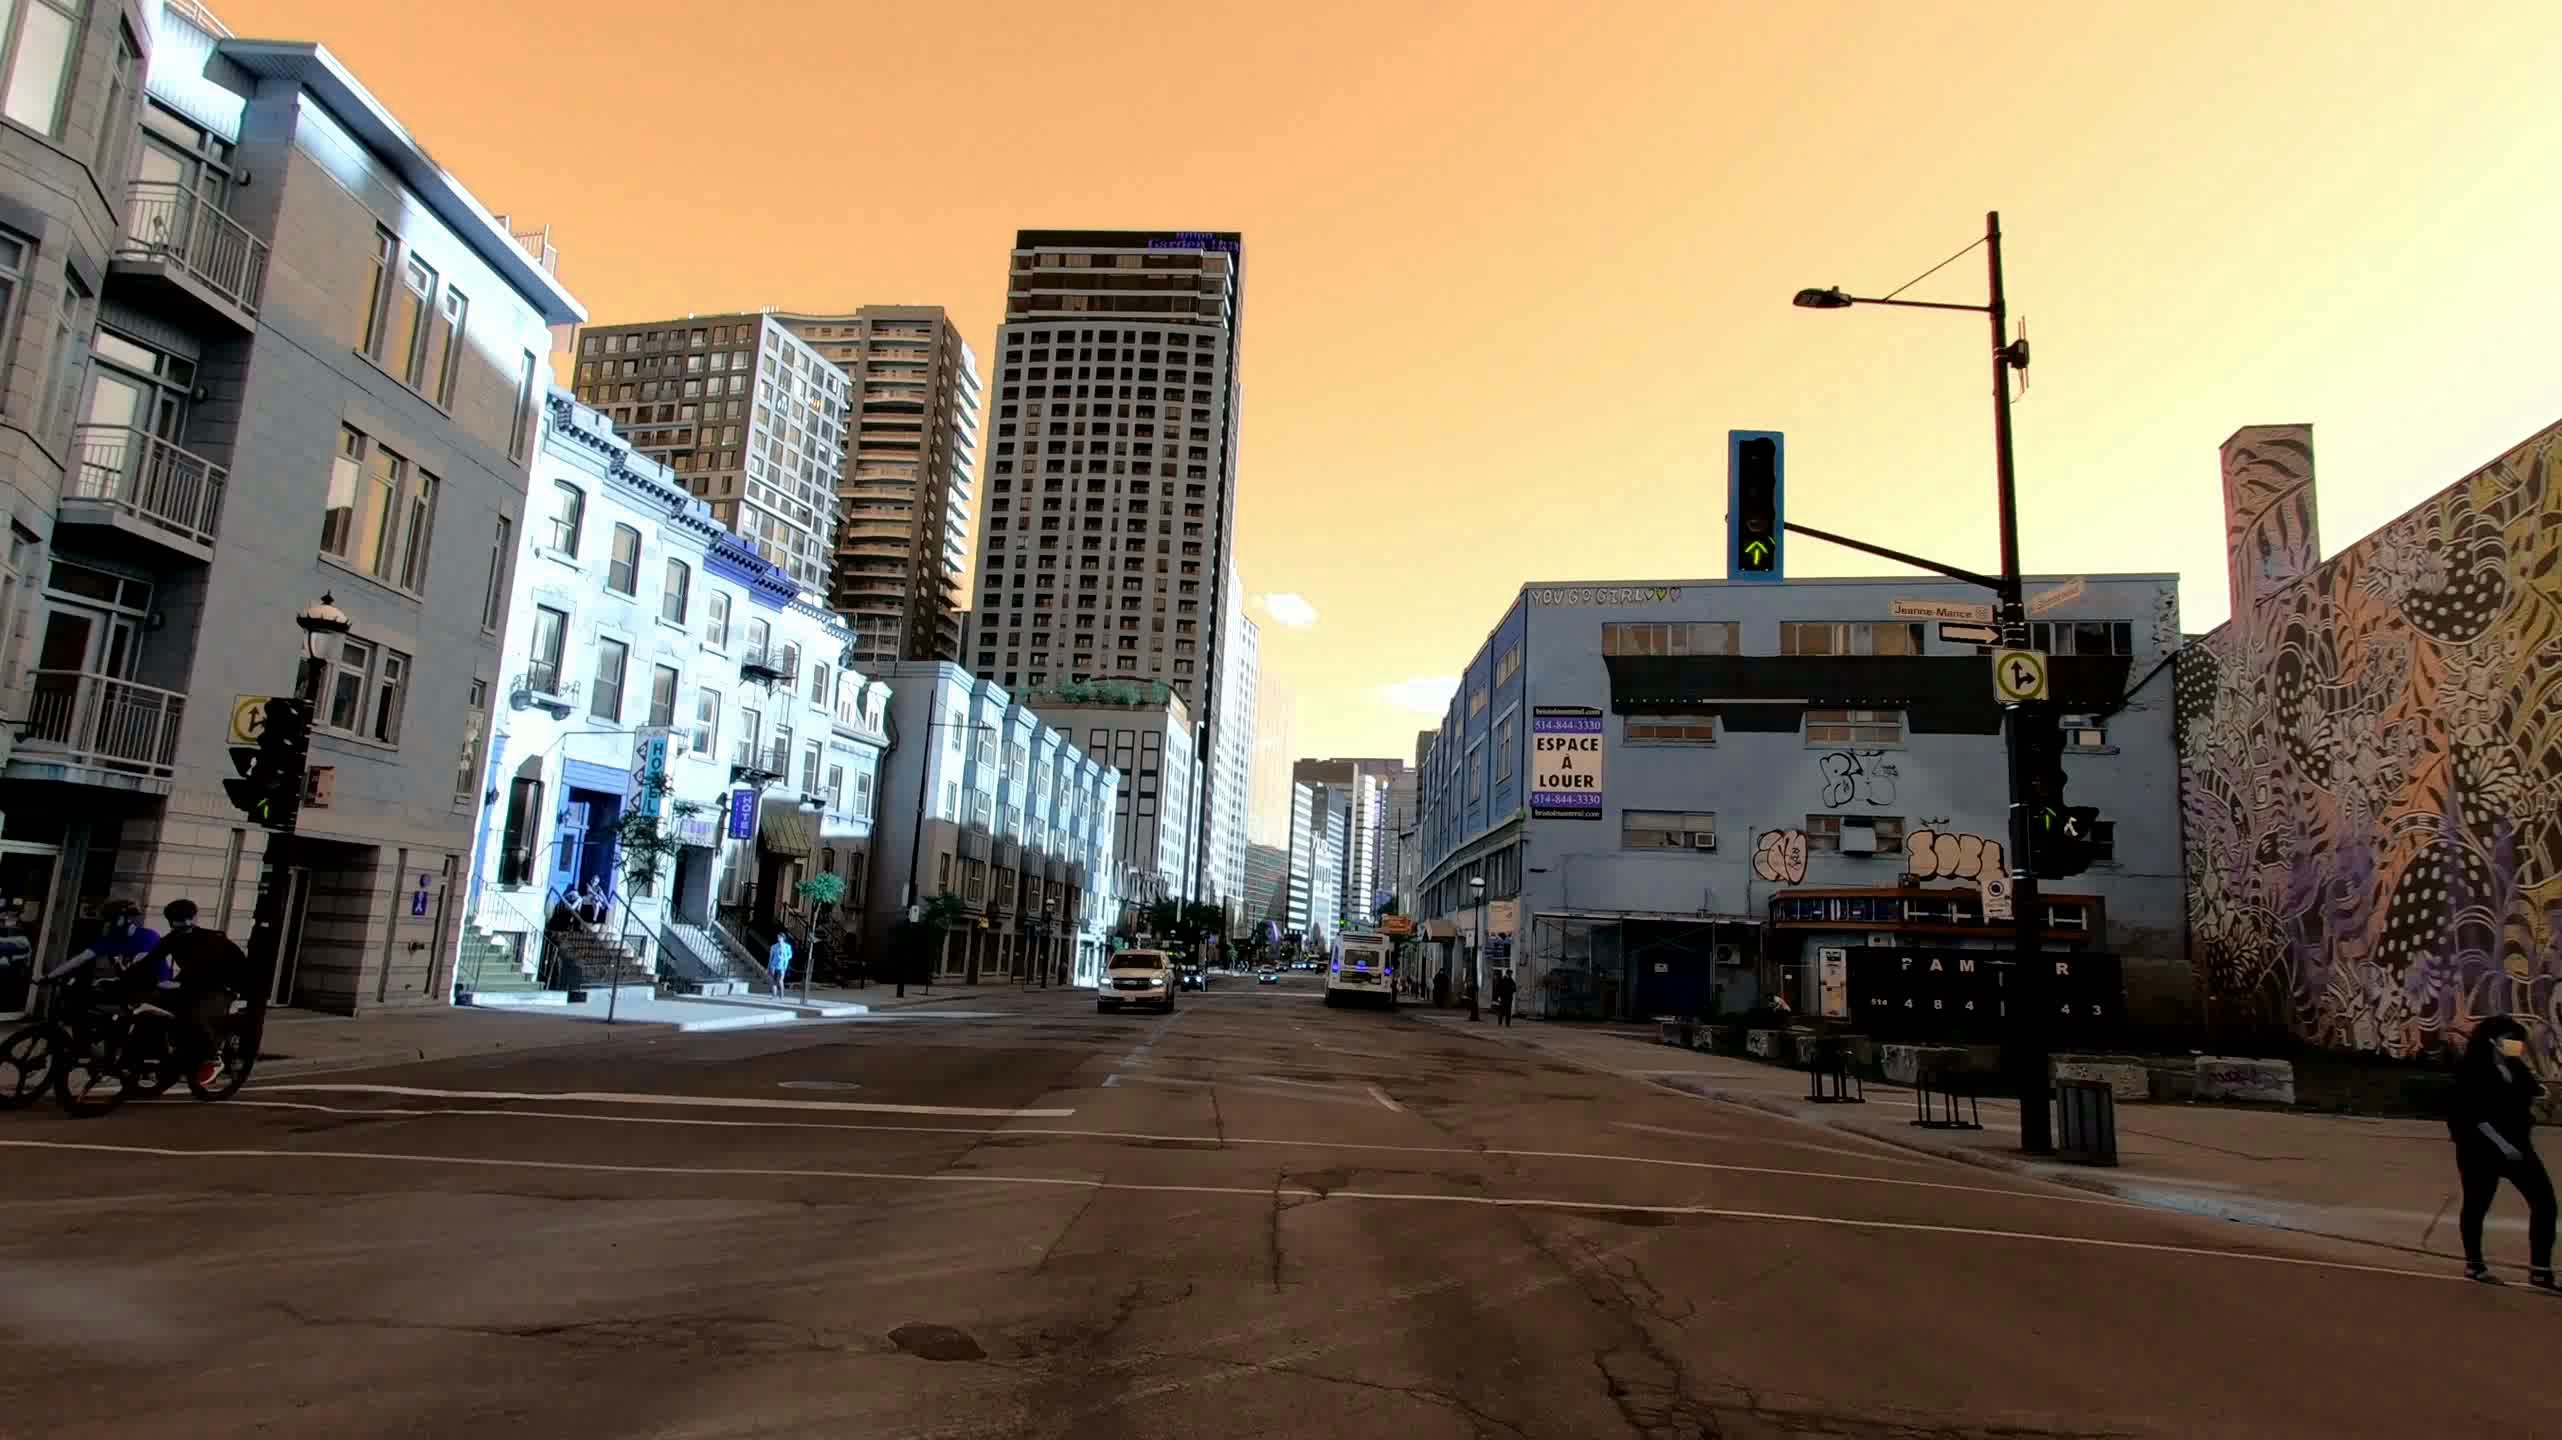

Время инференса: 155.4 ms
Кадр после детекции:


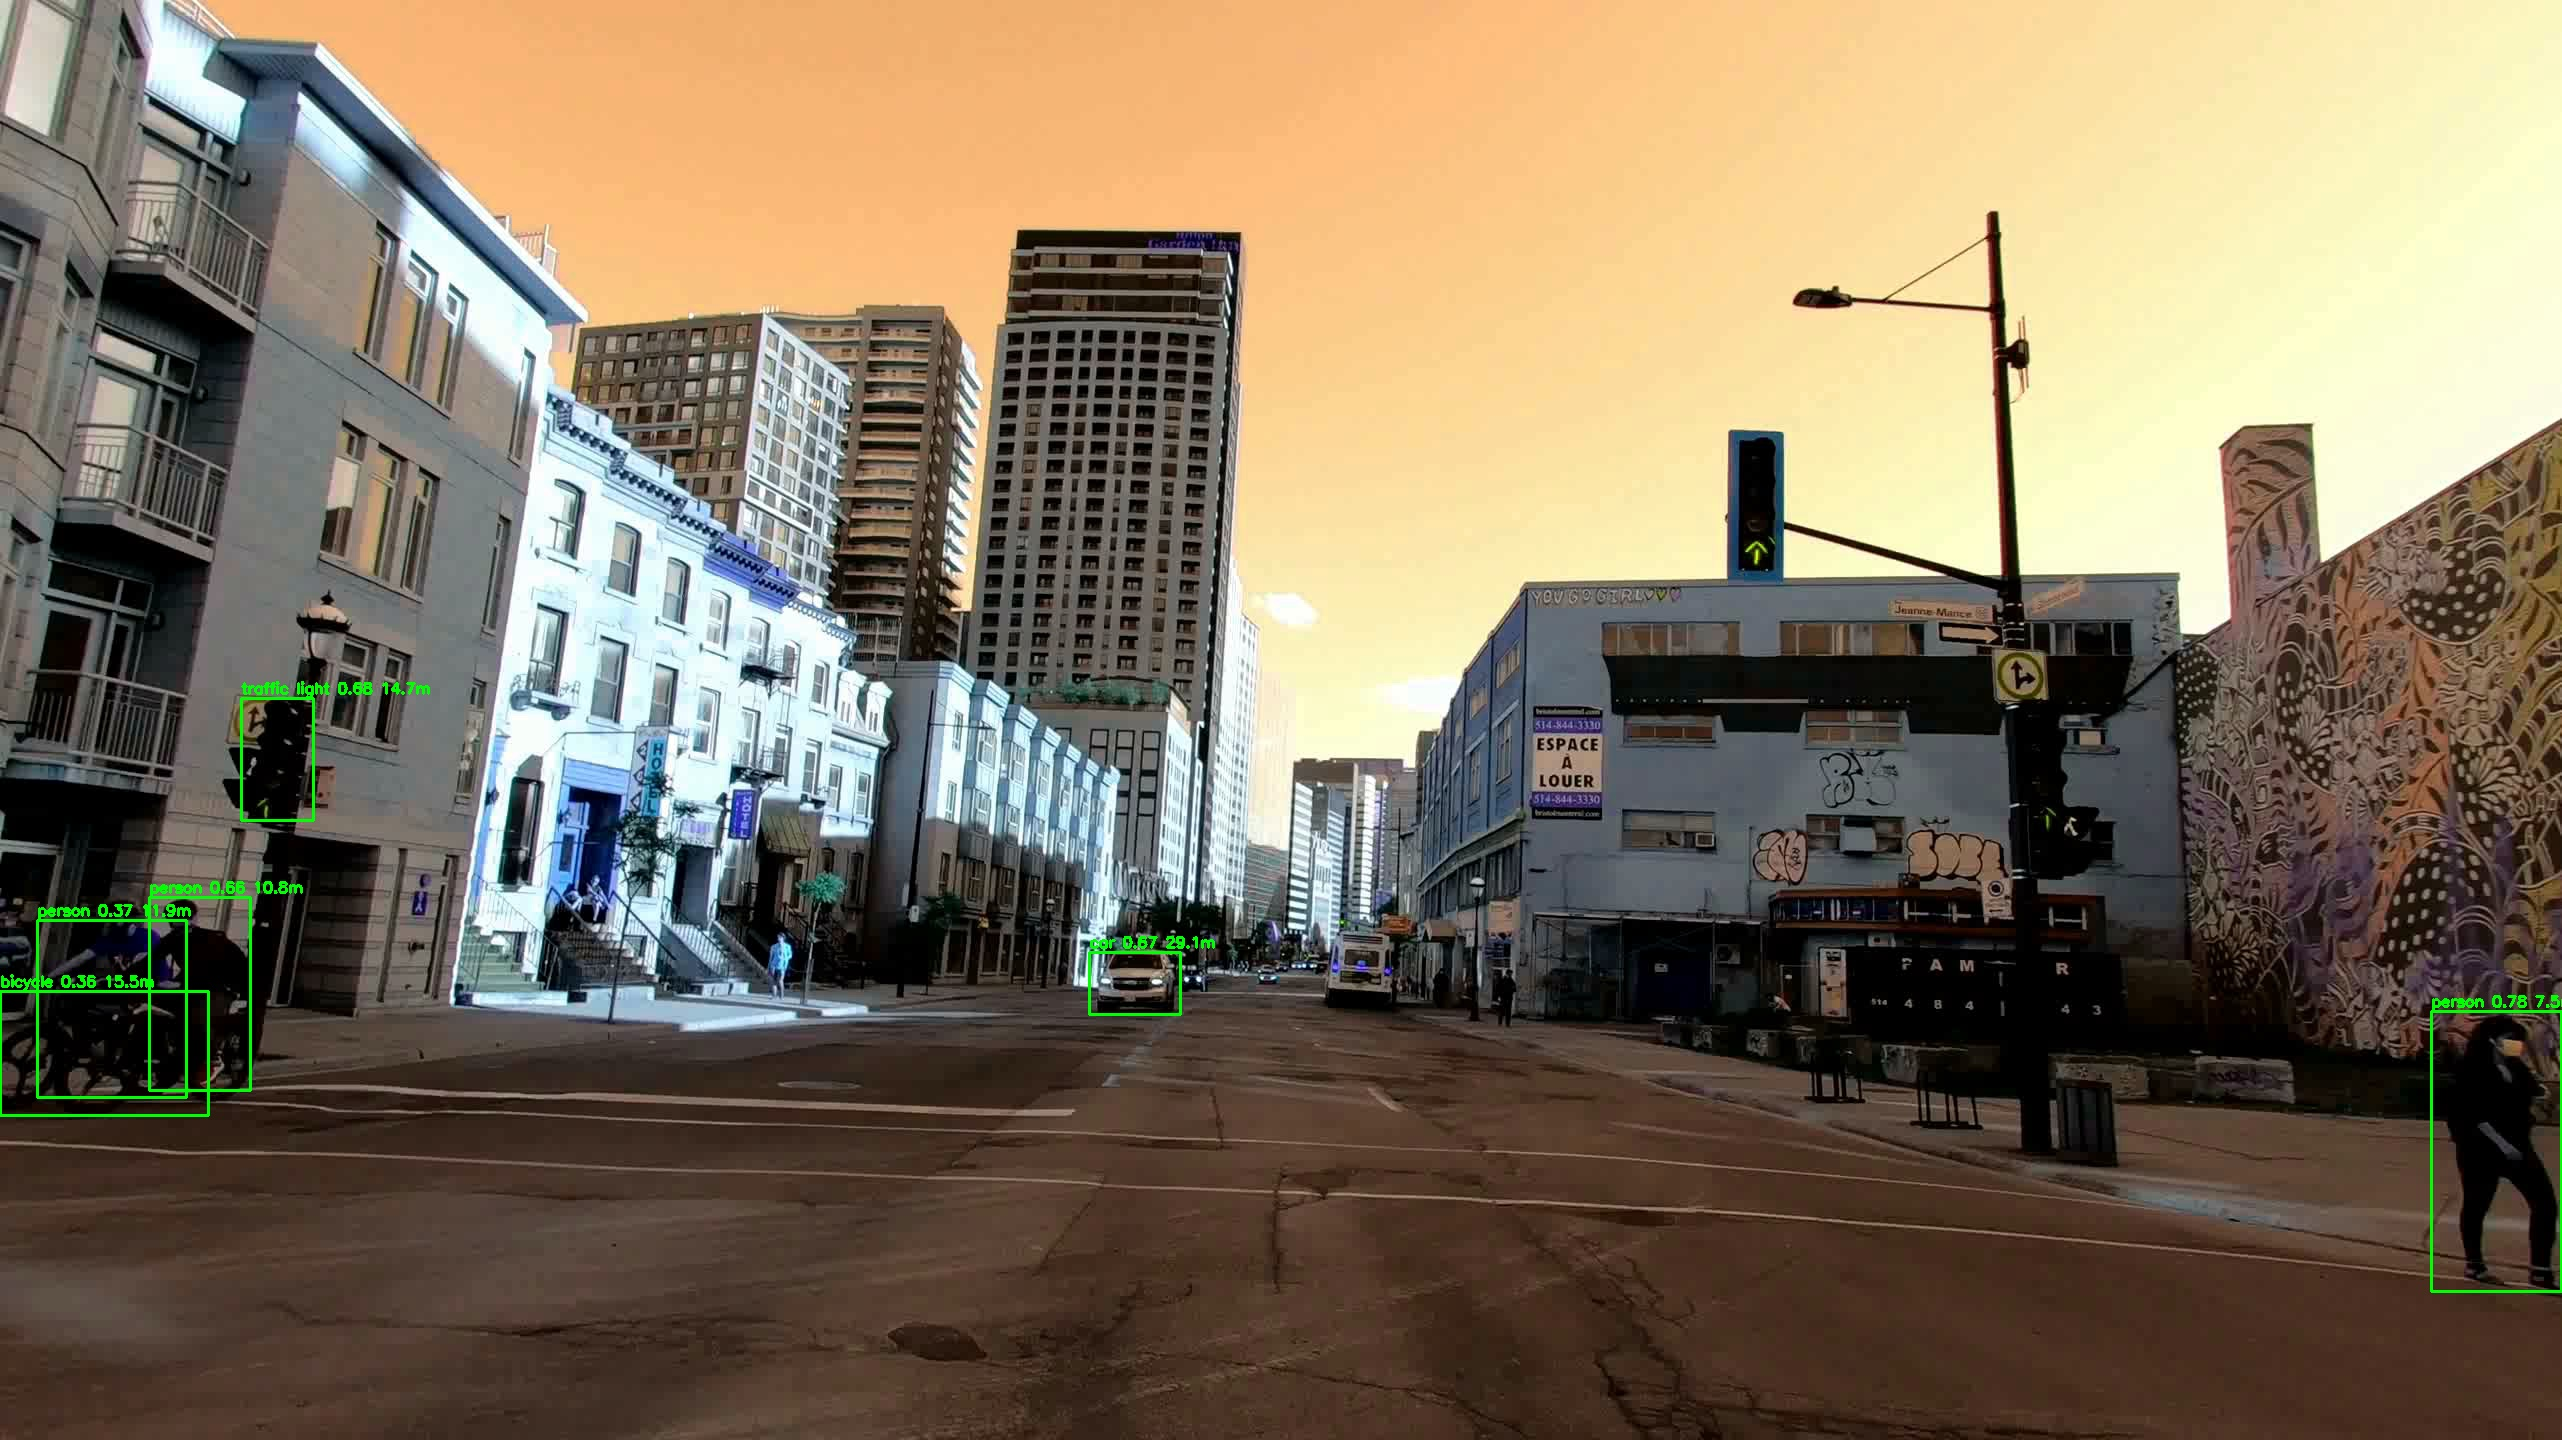

In [9]:
import cv2
from IPython.display import display, Image
import numpy as np
import time


def show_image(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _, encoded_img = cv2.imencode('.jpg', img_rgb)
    display(Image(data=encoded_img.tobytes()))


cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()  # первый кадр
cap.release()

if not ret:
    raise RuntimeError("Не удалось прочитать кадр из видео")

print(" Оригинальный кадр:")
show_image(frame)

detector = YOLOv8(model_path, conf_thres=0.3, iou_thres=0.5)
detector.get_input_details()
detector.get_output_details()

t0 = time.time()
boxes, scores, cls_ids, distances = detector(frame)
t_infer = time.time() - t0
print(f"Время инференса: {t_infer*1000:.1f} ms")

frame_out = frame.copy()
for box, score, cls_id, dist in zip(boxes, scores, cls_ids, distances):
    x1, y1, x2, y2 = box.astype(int)
    label = f"{detector.get_class_name(cls_id)} {score:.2f} {dist:.1f}m"
    color = (0, 255, 0) 
    cv2.rectangle(frame_out, (x1, y1), (x2, y2), color, 2)
    cv2.putText(frame_out, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

print("Кадр после детекции:")
show_image(frame_out)
